# Wikispeedia

Imports

In [4]:
import pandas as pd
import networkx as nx
import nx_parallel as nxp
import matplotlib.pyplot as plt
import numpy as np
import random

import os
import json

from joblib import parallel_config, Parallel, delayed

Enable networkx's config for nx-parallel and set global configs

In [5]:
nx.config.backends.parallel.active = True

nxp_config = nx.config.backends.parallel
nxp_config.n_jobs = -1
nxp_config.verbose = 50

Read graph data

In [6]:
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', delimiter='\t', names=['linkSource', 'linkTarget'], header=None, comment="#")
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', delimiter='\t', names=['article'], header=None, comment="#")

Read game data

In [7]:
paths_finished = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', delimiter='\t', usecols=[3], names=['path'], header=None, comment="#")
paths_finished['path'] = paths_finished['path'].apply(lambda x: x.split(';'))

paths_unfinished = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', delimiter='\t', usecols=[3, 4], names=['path', 'target'], header=None, comment="#")
paths_unfinished['path'] = paths_unfinished['path'].apply(lambda x: x.split(';'))

Filter game data to discard '<'

In [8]:
def filter_paths(paths):
    filtered_paths = [] 
    for path in paths:
        indices  = [index for (index, item) in enumerate(path) if item == '<']
        filter_indices = []; 
        for index in indices: filter_indices.extend([index - 1, index])
        filtered_paths.append([item for index, item in enumerate(path) if index not in filter_indices])
    return filtered_paths

paths_finished = filter_paths(paths_finished['path'])
paths_unfinished['path'] = filter_paths(paths_unfinished['path'])

In [9]:
paths_unfinished['path'][10][0]

'Battle_of_Gettysburg'

Generate the graph

In [10]:
G = nx.from_pandas_edgelist(links, source='linkSource', target='linkTarget')
disconnected_nodes = set(articles['article'].tolist()) - set(G.nodes)
G.add_nodes_from(disconnected_nodes)

H = nxp.ParallelGraph(G)

Plot the graph

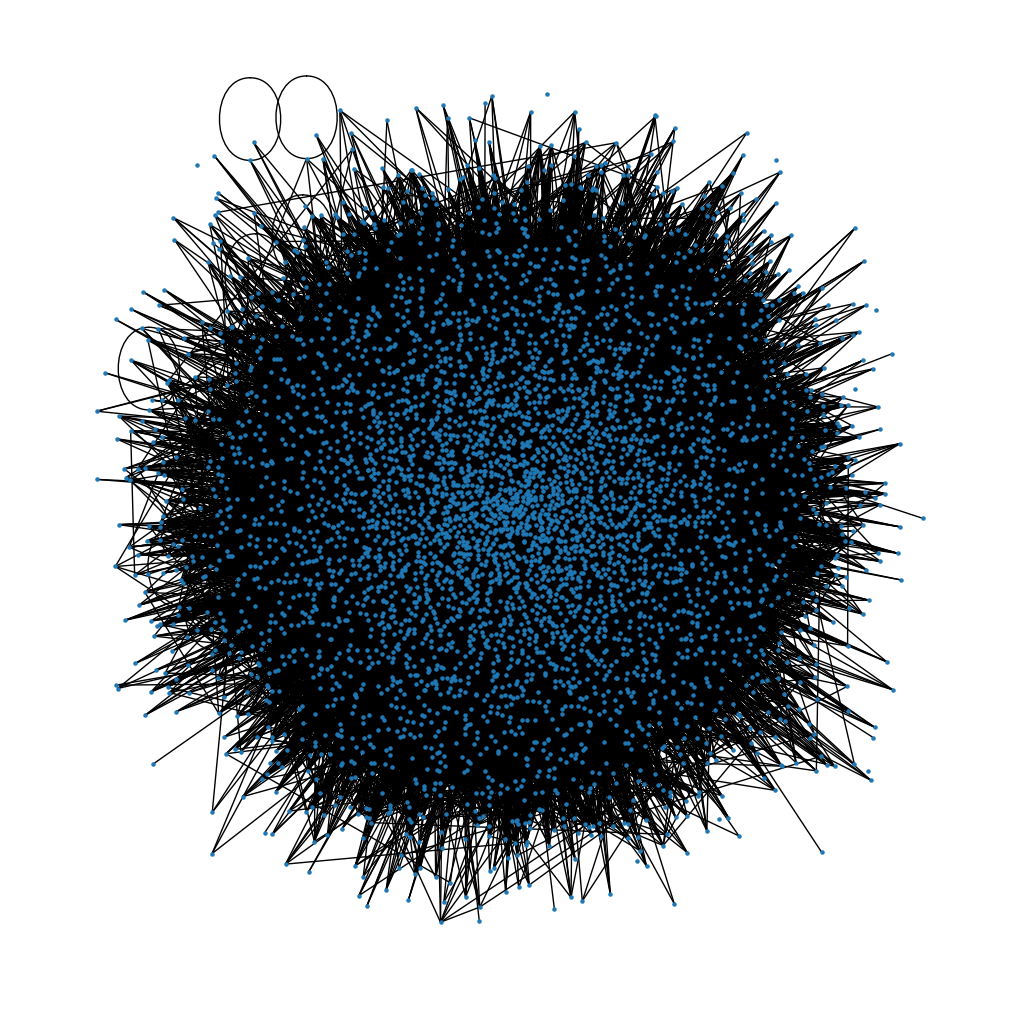

In [12]:
positions = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(1, figsize=(10, 10))
nx.draw(G, pos=positions, node_size=5)
plt.show()

Compute the shortest-path betweenness centrality for nodes (not approximated)

In [13]:
nodes_bc = nxp.betweenness_centrality(H);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.1min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.2min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  2.2min remaining:   43.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.2min finished


Analyze finished paths

In [14]:
unique_couples = []

for path in paths_finished:
    src = path[0]
    dst = path[-1]
    if(not [src, dst] in unique_couples):
        unique_couples.append([src, dst])

print(len(unique_couples))

28718


In [15]:
def shortest_paths_f(couple):
    try:
        shortest_paths_generator = nx.all_shortest_paths(G, couple[0], couple[1])
        shortest_paths = list(shortest_paths_generator)
        if not os.path.isdir('shortest_paths'):
            os.makedirs('shortest_paths')
        with open('shortest_paths/' + couple[0] + '#' + couple[1] + '.txt', 'w') as out_file:
            out_file.write(json.dumps(shortest_paths))
    except Exception as e:
        print(couple[0] + '#' + couple[1] + ' exception : ' + str(e))

In [16]:
Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_couples)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
def compare_paths(player_path, folder1, folder2):
    
    first_player_node = player_path[0]
    last_player_node = player_path[-1]
    
    try:
        with open(folder1 + '/' + first_player_node + '#' + last_player_node + '.txt') as in_file:
            optimal_paths = json.loads(in_file.read())

        best_beg_equal_nodes = 0
        best_end_equal_nodes = 0
        best_total_equal_nodes = 0
        
        for path in optimal_paths:
            
            i = 0
            while(i < len(path) and player_path[i] == path[i]): i = i + 1
            beg_equal_nodes = i
            
            i = -1
            while(i > -len(path) and player_path[i] == path[i]): i = i - 1
            end_equal_nodes = -i

            total_equal_nodes = len(list(set(path).intersection(player_path)))

            if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
            if end_equal_nodes > best_end_equal_nodes: best_end_equal_nodes = end_equal_nodes
            if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

        if not os.path.isdir(folder2):
            os.makedirs(folder2)
        with open(folder2 + '/' + first_player_node + '#' + last_player_node + '.txt', 'a') as out_file:
            out_file.write(
                str(len(path)) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_end_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + '\n'
            )

    except Exception as e:
        print(first_player_node + '#' + last_player_node + ' exception : ' + str(e))
    
# Parallel(n_jobs=-1)(delayed(compare_paths)(path) for path in paths_finished)

for path in paths_finished:
    compare_paths(path, 'shortest_paths', 'equal_nodes')

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License exception : [Errno 2] No such file or directory: 'shortest_paths/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


KeyboardInterrupt: 

Analyze unfinished paths

In [ ]:
unique_unfinished_couples = []

for index, row in paths_unfinished.iterrows():
    src = row['path'][0]
    dst = row['target']
    if(not [src, dst] in unique_unfinished_couples):
        unique_unfinished_couples.append([src, dst])

Parallel(n_jobs=-1)(delayed(shortest_paths_f)(couple) for couple in unique_unfinished_couples)

In [ ]:
def compare_unfinished_paths(player_path, target, folder1, folder2):
    
    first_player_node = player_path[0]
    last_player_node = target
    
    try:
        with open(folder1 + '/' + first_player_node + '#' + last_player_node + '.txt') as in_file:
            optimal_paths = json.loads(in_file.read())

        best_beg_equal_nodes = 0
        best_total_equal_nodes = 0
        
        for path in optimal_paths:
            
            i = 0
            while(i < len(path) and i < len(player_path) and player_path[i] == path[i]): i = i + 1
            beg_equal_nodes = i

            total_equal_nodes = len(list(set(path).intersection(player_path)))

            if beg_equal_nodes > best_beg_equal_nodes: best_beg_equal_nodes = beg_equal_nodes
            if total_equal_nodes > best_total_equal_nodes: best_total_equal_nodes = total_equal_nodes

        if not os.path.isdir(folder2):
            os.makedirs(folder2)
        with open(folder2 + '/' + first_player_node + '#' + last_player_node + '.txt', 'a') as out_file:
            out_file.write(
                str(len(path)) + ' ' + 
                str(len(player_path)) + ' ' +
                str(best_beg_equal_nodes) + ' ' + 
                str(best_total_equal_nodes) + '\n'
            )

    except Exception as e:
        print(first_player_node + '#' + last_player_node + ' exception : ' + str(e))


for index, row in paths_unfinished.iterrows():
    compare_unfinished_paths(row['path'], row['target'], 'shortest_paths', 'equal_nodes_unfinished')

Length difference histogram for finished paths

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License : [Errno 2] No such file or directory: 'equal_nodes/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


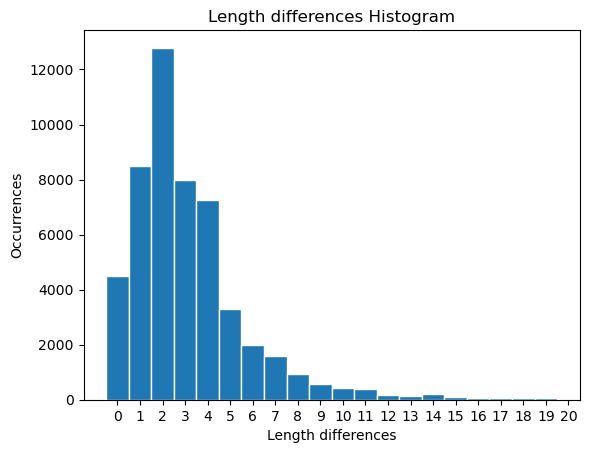

In [11]:
len_diff = []

for path in paths_finished:
    try:
        with open('equal_nodes' + '/' + path[0] + '#' + path[-1] + '.txt') as in_file:
            s = in_file.read().split()
            optimal_len = int(s[0])
            player_len = int(s[1])
            len_diff.append(player_len - optimal_len)
    except Exception as e:
        print(path[0] + '#' + path[-1] + ' : ' + str(e))

plt.hist(len_diff, bins=range(21), align='left', edgecolor='white')
plt.xticks(range(21))
plt.xlabel('Length differences')
plt.ylabel('Occurrences')
plt.title('Length differences Histogram')
plt.show()

Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License : [Errno 2] No such file or directory: 'equal_nodes/Bird#Wikipedia_Text_of_the_GNU_Free_Documentation_License.txt'


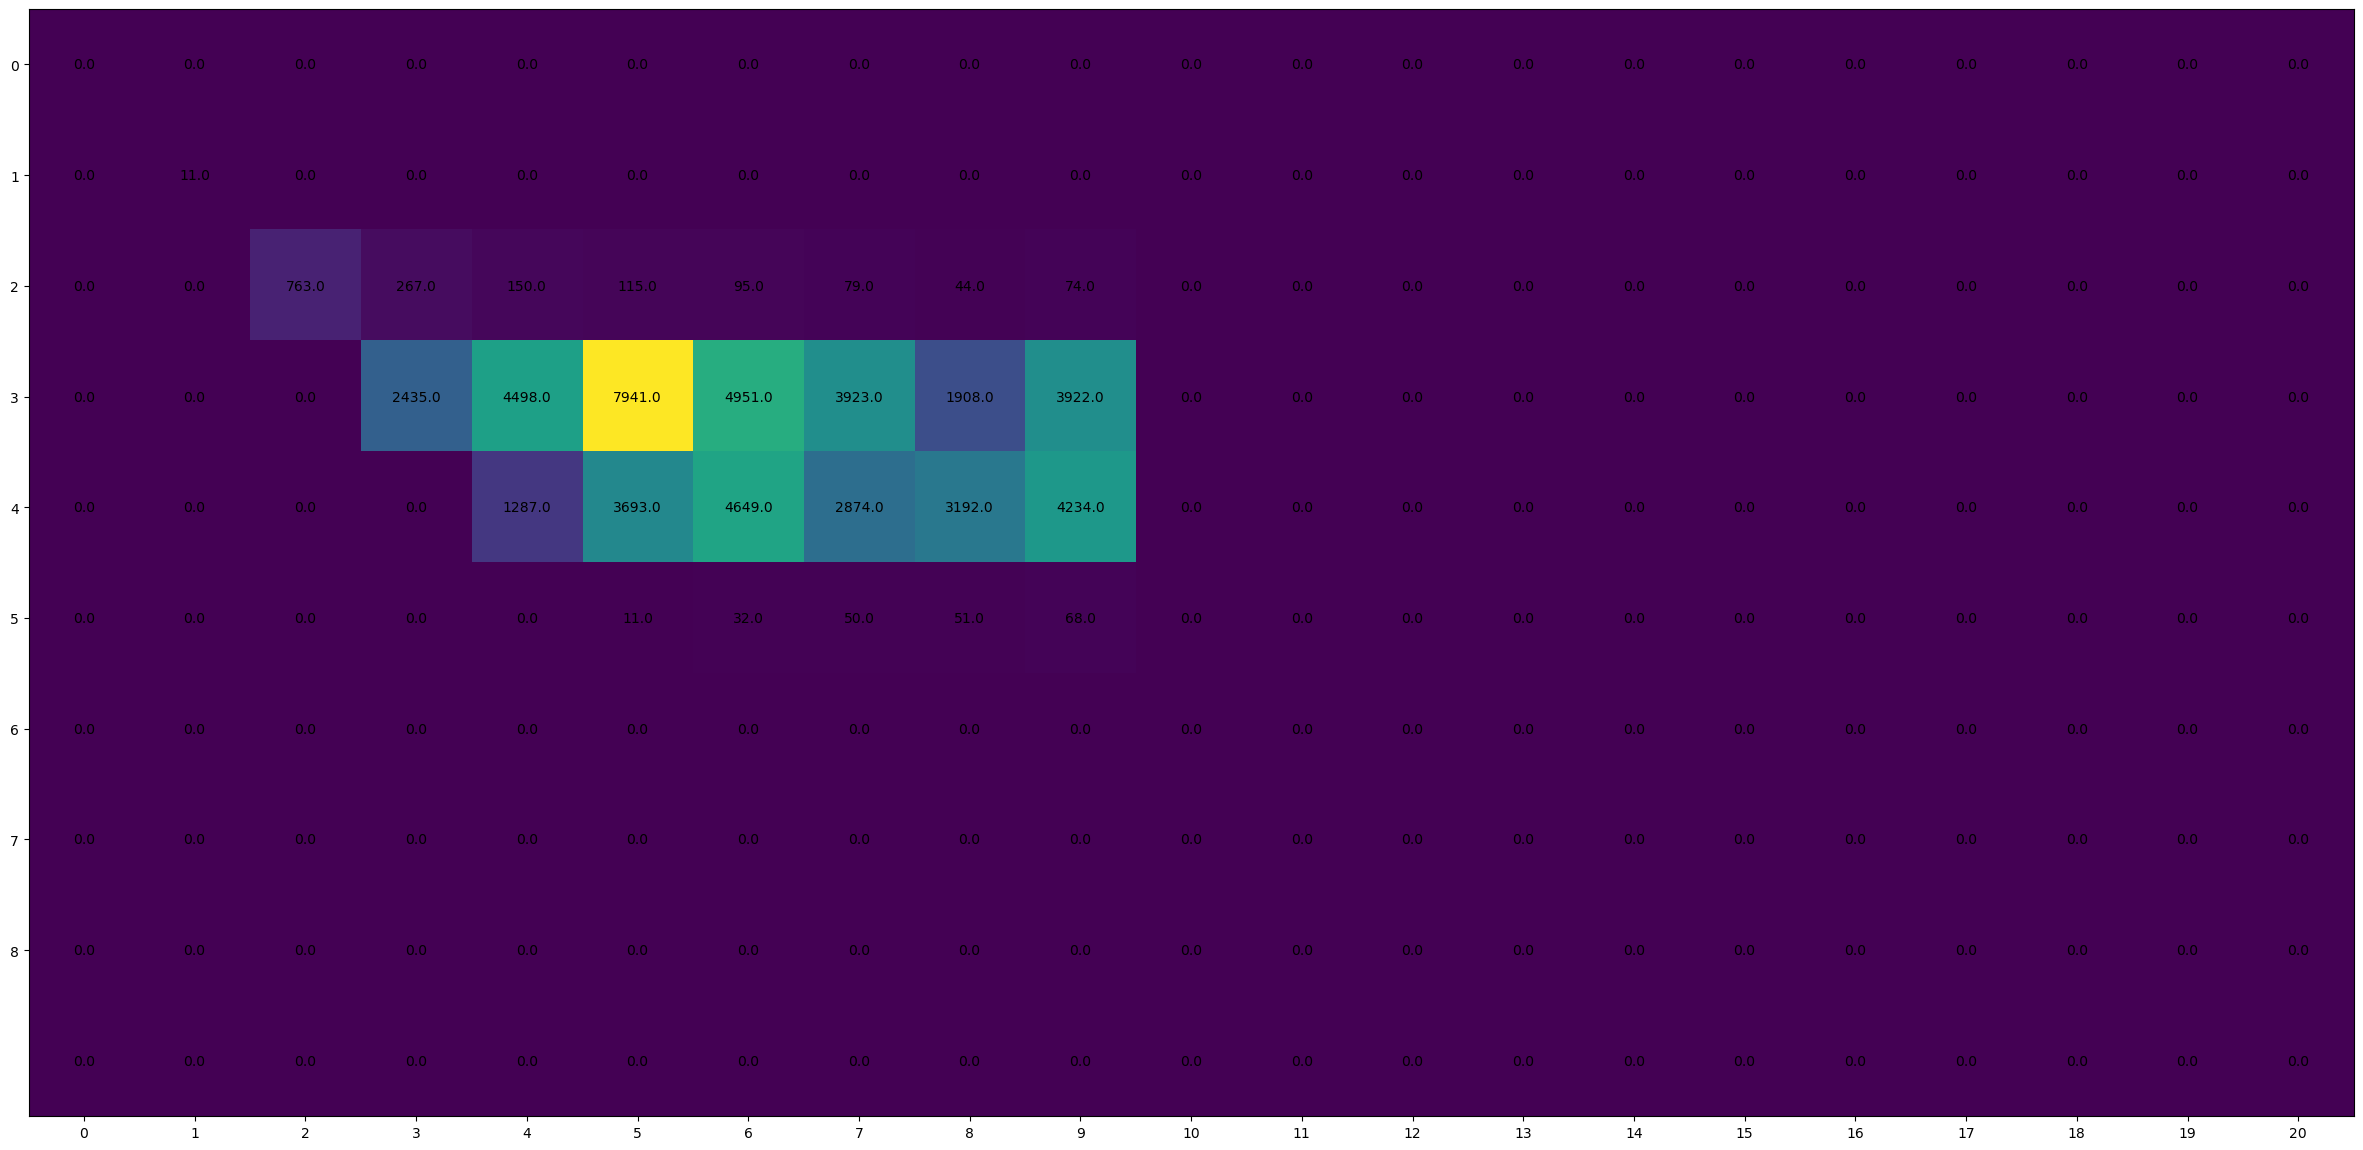

In [24]:
len_map = np.zeros((10, 21))
optimal_len_freq = np.zeros(10)

for path in paths_finished:
    try:
        with open('equal_nodes' + '/' + path[0] + '#' + path[-1] + '.txt') as in_file:
            s = in_file.read().split()
            optimal_len = int(s[0])
            optimal_len_freq[optimal_len] = optimal_len_freq[optimal_len] + 1
            player_len = int(s[1])
            player_len = min(player_len, 9)
            len_map[optimal_len][player_len] = len_map[optimal_len][player_len] + 1
    except Exception as e:
        print(path[0] + '#' + path[-1] + ' : ' + str(e))
        
#for index in range(len(len_map)):
#    len_map[index] = len_map[index]/optimal_len_freq[index]
plt.figure(figsize=(30, 30))
plt.imshow(len_map)
plt.xticks(range(21))
plt.yticks(range(9))
for (j,i),label in np.ndenumerate(len_map):
    plt.text(i,j,label,ha='center',va='center')

Visualize the 10 most central nodes, with respect to the betweennes centrality and count how many users used them to conclude their game

In [22]:
sorted_bc = sorted(nodes_bc.items(), key=lambda item: item[1], reverse=True)
for i in range(1, 11):
  print(i, sorted_bc[i])

for i in range(1, 11):
  count = 0
  for path in paths_finished:
    if sorted_bc[i][0] in path:
      count += 1
  print("Percentage of", sorted_bc[i][0], "=", count/len(paths_finished))

1 ('United_Kingdom', 0.047140056743262077)
2 ('Europe', 0.04442508677538769)
3 ('France', 0.03661771007015328)
4 ('England', 0.03342206625169744)
5 ('World_War_II', 0.025432353143485176)
6 ('Germany', 0.023007921661402024)
7 ('English_language', 0.020111050737573844)
8 ('Africa', 0.01974485634533934)
9 ('London', 0.018907246019044824)
10 ('Australia', 0.01739070176832979)
Percentage of United_Kingdom = 0.07217740364004832
Percentage of Europe = 0.08256362290034686
Percentage of France = 0.029697182275225067
Percentage of England = 0.061459916598464476
Percentage of World_War_II = 0.04288943450641101
Percentage of Germany = 0.033126778128531896
Percentage of English_language = 0.026657313223430377
Percentage of Africa = 0.05237928212323161
Percentage of London = 0.017888460189407224
Percentage of Australia = 0.018745859152733933



Method to perform a random walk of at most n steps

In [23]:
def do_random_walk(g, source, destination, n):
  crossed_nodes = []
  current_node = source
  crossed_nodes.append(current_node)
  for i in range(n):
    if current_node == destination:
      break
    list_neighbors = list(g.neighbors(current_node))
    if len(list_neighbors)==0:
      break
    else:
      current_node = random.choice(list_neighbors)
      crossed_nodes.append(current_node)
  return crossed_nodes

Perform "number_of_random_attempts" random walks on a subset of source and destination nodes picked casually

In [25]:
number_of_finished_paths = 20
number_of_random_attempts = 20
max_steps = 100

for i in range(number_of_finished_paths):
  random_i = random.choice([i for i in range(len(paths_finished))])
  source, destination = paths_finished[random_i][0], paths_finished[random_i][-1]
  print(source, "-->", destination)
  for j in range(number_of_random_attempts):
    crossed_nodes = do_random_walk(G, source, destination, max_steps)
    if crossed_nodes[-1] == destination:
      print("Correct path:, number of steps:", len(crossed_nodes))
      print(crossed_nodes)
    #else:
      #print("Wrong random path")

Beijing --> European_Parliament
British_Virgin_Islands --> Magma
Correct path:, number of steps: 77
['British_Virgin_Islands', 'Transport', 'British_Indian_Ocean_Territory', 'United_States', 'John_F._Kennedy', 'London', 'Harold_Wilson', 'Robert_Peel', 'William_Ewart_Gladstone', 'Chartism', 'Australia', 'Madagascar', 'Israel', 'Saudi_Arabia', 'Sheikh_Mujibur_Rahman', 'Kolkata', 'Science', 'Statistics', 'University', 'England', 'Isis', 'Roman_mythology', 'Ancient_Rome', 'Dayuan', 'Issyk_Kul', 'Glacier', 'Geometry', 'Measurement', 'Milky_Way', 'Human', 'Meat', 'Rabbit', 'Coal_Tit', 'North_Africa', 'Water', 'Helium', 'Neptune', 'Cloud', 'Chew_Valley', 'Wren', 'Fauna_of_Australia', 'India', 'Chess', 'People%27s_Republic_of_China', 'Nepal', 'Pyongyang', 'Rio_de_Janeiro', 'Bras%C3%ADlia', 'Capital', 'Lom%C3%A9', 'Coffee', 'Tea', 'Central_African_Republic', 'Armenia', 'David_III_of_Tao', 'Emirate', 'Qatar', 'World_Trade_Organization', 'Palau', 'Australia', 'Devonian', 'Fish', 'Nurse_sharks', '